In [ ]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import os
import zipfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Unzip the dataset
with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Lets see the directory structure of tiny-imagenet-200
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

list_files('tiny-imagenet-200')

In [ ]:
# Path and Files
path = './tiny-imagenet-200/train/'
wnid_labels = dict(line.strip().split('\t') for line in open('./tiny-imagenet-200/words.txt'))  # Corrected path
dirs = os.listdir(path)

In [44]:
# Define the function to sample images
def rsample_images(n):
    """
    Sample n random images from the train directory along with their English wnid representations and bounding boxes.

    Args:
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    for _ in range(n):
        random_dir = random.choice(dirs)
        random_image = random.choice(os.listdir(os.path.join(path, random_dir, 'images')))
        box_data = [line.strip().split('\t') for line in open(os.path.join(path, random_dir, f"{random_dir}_boxes.txt"))]
        box_for_image = [box for box in box_data if box[0] == random_image][0]
        samples_with_boxes.append((random_dir, os.path.join(path, random_dir, 'images', random_image), box_for_image))

    return samples_with_boxes

In [45]:
def sample_images_by_wnid(wnid, n):
    """
    Sample 'n' images of a specific wnid from the train directory along with their English wnid representations and bounding boxes.

    Args:
    wnid (str): The wnid of the images to sample.
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    image_dir = os.path.join(path, wnid, 'images')
    box_data = [line.strip().split('\t') for line in open(os.path.join(path, wnid, f"{wnid}_boxes.txt"))]
    
    for image_name in os.listdir(image_dir)[:n]:
        box_for_image = [box for box in box_data if box[0] == image_name][0]
        samples_with_boxes.append((wnid, os.path.join(image_dir, image_name), box_for_image))

    return samples_with_boxes


In [46]:
# Define the function to display images
def display_images(samples_with_boxes):
    """
    Display images along with their English wnid representations and bounding boxes.

    Args:
    samples_with_boxes (List[Tuple]): A list of tuples where each tuple contains wnid, image path, and bounding box.

    Returns:
    None
    """
    n = len(samples_with_boxes)
    fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
    if n == 1:
        axs = [axs]
    for i, (wnid, img_path, box) in enumerate(samples_with_boxes):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].title.set_text(wnid_labels[wnid])
        axs[i].title.set_fontsize(8)

        x, y, w, h = map(int, box[1:])
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

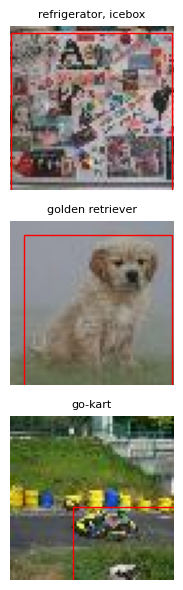

In [47]:
display_images(rsample_images(3))

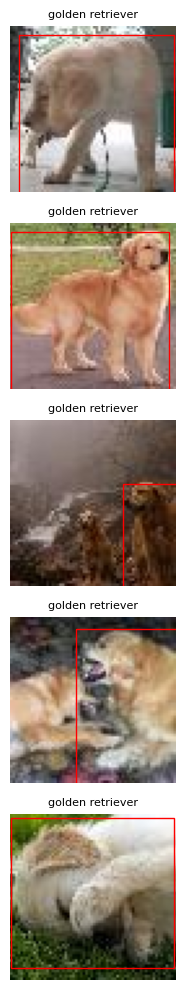

In [53]:
display_images(sample_images_by_wnid('n02099601',5))